Результаты для хеш-функции: hash_mult_add
       m  k  Ложноположительные срабатывания
0   1000  3                            0.867
1   1000  5                            0.967
2   1000  7                            0.989
3   5000  3                            0.239
4   5000  5                            0.379
5   5000  7                            0.502
6  10000  3                            0.098
7  10000  5                            0.164
8  10000  7                            0.222


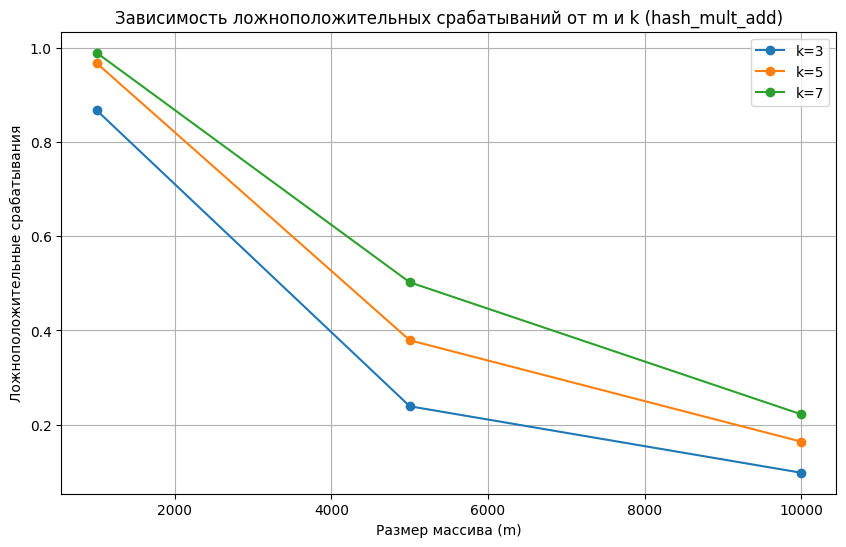

Результаты для хеш-функции: hash_xor
       m  k  Ложноположительные срабатывания
0   1000  3                            0.884
1   1000  5                            0.978
2   1000  7                            0.995
3   5000  3                            0.197
4   5000  5                            0.283
5   5000  7                            0.388
6  10000  3                            0.075
7  10000  5                            0.099
8  10000  7                            0.142


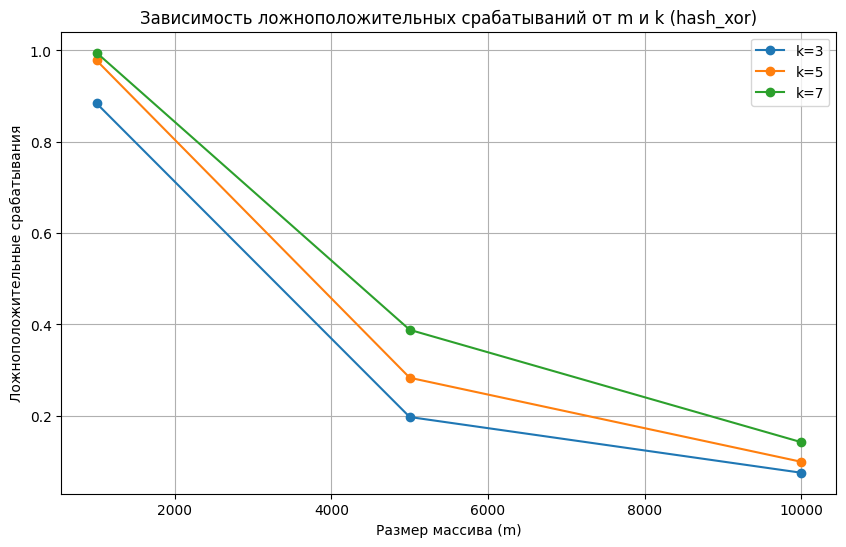

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def hash_mult_add(item, m):
    hash_value = 0
    for char in str(item):
        hash_value = (hash_value * 31 + ord(char)) 
    return hash_value % m

def hash_xor(item, m):
    hash_value = 0
    for char in str(item):
        hash_value ^= (hash_value << 5) + ord(char) + (hash_value >> 2)
    return hash_value % m

class CountingBloomFilter:
    def __init__(self, m, k, hash_fn):
        self.m = m
        self.k = k
        self.hash_fn = hash_fn
        self.counter_array = [0] * m

    def add(self, item):
        for i in range(self.k):
            index = self.hash_fn(f"{item}_{i}", self.m)
            self.counter_array[index] += 1

    def contains(self, item):
        for i in range(self.k):
            index = self.hash_fn(f"{item}_{i}", self.m)
            if self.counter_array[index] == 0:
                return False
        return True

    def remove(self, item):
        for i in range(self.k):
            index = self.hash_fn(f"{item}_{i}", self.m)
            if self.counter_array[index] > 0:
                self.counter_array[index] -= 1

    def __or__(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые m и k")
        new_filter = CountingBloomFilter(self.m, self.k, self.hash_fn)
        new_filter.counter_array = [a + b for a, b in zip(self.counter_array, other.counter_array)]
        return new_filter

    def __and__(self, other):
        if self.m != other.m or self.k != other.k:
            raise ValueError("Фильтры должны иметь одинаковые m и k")
        new_filter = CountingBloomFilter(self.m, self.k, self.hash_fn)
        new_filter.counter_array = [min(a, b) for a, b in zip(self.counter_array, other.counter_array)]
        return new_filter

def false_positive_rate(bloom_filter, added_elements, test_elements):
    for element in added_elements:
        bloom_filter.add(element)

    false_positives = 0
    for element in test_elements:
        if bloom_filter.contains(element):
            false_positives += 1

    return false_positives / len(test_elements)

def evaluate_false_positives(n, m_values, k_values, hash_fn):
    results = []
    for m in m_values:
        for k in k_values:
            bloom_filter = CountingBloomFilter(m, k, hash_fn)
            added_elements = np.random.randint(0, 100000, n)
            test_elements = np.random.randint(100001, 200000, n)
            fp_rate = false_positive_rate(bloom_filter, added_elements, test_elements)
            results.append((m, k, fp_rate))
    return results

n = 1000  
m_values = [1000, 5000, 10000]  
k_values = [3, 5, 7]

hash_functions = {
    "hash_mult_add": hash_mult_add,
    "hash_xor": hash_xor,
}

for hash_name, hash_fn in hash_functions.items():
    print(f"Результаты для хеш-функции: {hash_name}")
    results = evaluate_false_positives(n, m_values, k_values, hash_fn)

    df = pd.DataFrame(results, columns=["m", "k", "Ложноположительные срабатывания"])
    print(df)

    plt.figure(figsize=(10, 6))
    for k in k_values:
        m_list = [m for (m, k_val, _) in results if k_val == k]
        fp_list = [fp for (_, k_val, fp) in results if k_val == k]
        plt.plot(m_list, fp_list, marker='o', label=f"k={k}")

    plt.xlabel("Размер массива (m)")
    plt.ylabel("Ложноположительные срабатывания")
    plt.title(f"Зависимость ложноположительных срабатываний от m и k ({hash_name})")
    plt.legend()
    plt.grid()
    plt.show()

In [12]:
bf1 = CountingBloomFilter(m=1000, k=3, hash_fn=hash_xor)
bf2 = CountingBloomFilter(m=1000, k=3, hash_fn=hash_xor)

words1 = ["apple", "banana", "cherry"]
for word in words1:
    bf1.add(word)

words2 = ["banana", "cherry", "date"]
for word in words2:
    bf2.add(word)

bf_union = bf1 | bf2

bf_intersection = bf1 & bf2

print("Объединенный фильтр:")
for word in ["apple", "banana", "cherry", "date", "elderberry"]:
    if bf_union.contains(word):
        print(f"Слово '{word}' вероятно принадлежит объединенному множеству.")

print("\nПересечение фильтров:")
for word in ["apple", "banana", "cherry", "date", "elderberry"]:
    if bf_intersection.contains(word):
        print(f"Слово '{word}' вероятно принадлежит пересечению множеств.")

Объединенный фильтр:
Слово 'apple' вероятно принадлежит объединенному множеству.
Слово 'banana' вероятно принадлежит объединенному множеству.
Слово 'cherry' вероятно принадлежит объединенному множеству.
Слово 'date' вероятно принадлежит объединенному множеству.

Пересечение фильтров:
Слово 'banana' вероятно принадлежит пересечению множеств.
Слово 'cherry' вероятно принадлежит пересечению множеств.
